In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
import lightgbm as lgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from pathlib import Path
import tabmini

# Load the TabMini dataset
dataset = tabmini.load_dataset(reduced=False)

# Data Preprocessing
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

# Ensure target labels are binary (0 and 1)
def fix_target_labels(y):
    y = np.where(y == 2, 1, y)  # Replace label 2 with 1
    return y

# Define TabTransformer Model
class TabTransformer(nn.Module):
    def __init__(self, input_dim, num_classes, hidden_dim=128, num_heads=8, num_layers=4):
        super(TabTransformer, self).__init__()
        self.embedding = nn.Linear(input_dim, hidden_dim)
        self.transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=hidden_dim, nhead=num_heads),
            num_layers=num_layers
        )
        self.fc = nn.Linear(hidden_dim, num_classes)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.embedding(x)
        x = self.transformer(x)
        x = self.fc(x)
        return self.softmax(x)

# Training Function for TabTransformer
def train_tabtransformer(X_train, y_train, X_test):
    input_dim = X_train.shape[1]
    model = TabTransformer(input_dim=input_dim, num_classes=2)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    # Convert data to PyTorch tensors
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.long)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)

    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

    # Training loop
    for epoch in range(10):  # 10 epochs (can be increased for better performance)
        model.train()
        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
    
    # Inference
    model.eval()
    with torch.no_grad():
        predictions = model(X_test_tensor)
        y_pred = predictions.argmax(dim=1).numpy()

    return y_pred

# 1. LightGBM
# def train_lightgbm(X_train_scaled, y_train, X_test_scaled):
#     model = lgb.LGBMClassifier()
#     model.fit(X_train_scaled, y_train)
#     y_pred = model.predict(X_test_scaled)
#     return y_pred

# 2. Random Forest
def train_random_forest(X_train_scaled, y_train, X_test_scaled):
    model = RandomForestClassifier(n_estimators=100)
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    return y_pred

# 3. MLP-PLR (Multilayer Perceptron with Linear Regression)
# def train_mlp_plr(X_train_scaled, y_train, X_test_scaled):
#     model = MLPClassifier(hidden_layer_sizes=(100,), max_iter=500)
#     model.fit(X_train_scaled, y_train)
#     y_pred = model.predict(X_test_scaled)
#     return y_pred

# 4. SAINT (Using TabTransformer)
def train_saint(X_train_scaled, y_train, X_test_scaled):
    return train_tabtransformer(X_train_scaled, y_train, X_test_scaled)

# Model Evaluation
def evaluate_model(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    
    # Check if there are at least two classes in y_true
    if len(np.unique(y_true)) == 2:
        auc = roc_auc_score(y_true, y_pred)
    else:
        auc = None  # If only one class, AUC can't be computed
    
    return accuracy, f1, auc

# Create DataFrame to store results for each model
lightgbm_results = []
rf_results = []
mlp_plr_results = []
tabtransformer_results = []
saint_results = []

# Iterate through all datasets and train for each
for dataset_name, (X, y) in dataset.items():
    print(f"\nTraining with dataset: {dataset_name}")
    
    # Ensure target labels are binary (0 and 1)
    y = fix_target_labels(y)
    
    # Split dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Data Preprocessing
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Train and evaluate models for each dataset
    # # LightGBM
    # lightgbm_pred = train_lightgbm(X_train_scaled, y_train, X_test_scaled)
    # lightgbm_score = evaluate_model(y_test, lightgbm_pred)
    # lightgbm_results.append([dataset_name, *lightgbm_score])

    # Random Forest
    rf_pred = train_random_forest(X_train_scaled, y_train, X_test_scaled)
    rf_score = evaluate_model(y_test, rf_pred)
    rf_results.append([dataset_name, *rf_score])
    
    # # MLP-PLR
    # mlp_plr_pred = train_mlp_plr(X_train_scaled, y_train, X_test_scaled)
    # mlp_plr_score = evaluate_model(y_test, mlp_plr_pred)
    # mlp_plr_results.append([dataset_name, *mlp_plr_score])
    
    # # TabTransformer
    # tabtransformer_pred = train_tabtransformer(X_train_scaled, y_train, X_test_scaled)
    # tabtransformer_score = evaluate_model(y_test, tabtransformer_pred)
    # tabtransformer_results.append([dataset_name, *tabtransformer_score])
    
    # SAINT
    saint_pred = train_saint(X_train_scaled, y_train, X_test_scaled)
    saint_score = evaluate_model(y_test, saint_pred)
    saint_results.append([dataset_name, *saint_score])

# Convert results into DataFrame
lightgbm_results_df = pd.DataFrame(lightgbm_results, columns=["Dataset", "Accuracy", "F1", "AUC"])
rf_results_df = pd.DataFrame(rf_results, columns=["Dataset", "Accuracy", "F1", "AUC"])
mlp_plr_results_df = pd.DataFrame(mlp_plr_results, columns=["Dataset", "Accuracy", "F1", "AUC"])
tabtransformer_results_df = pd.DataFrame(tabtransformer_results, columns=["Dataset", "Accuracy", "F1", "AUC"])
saint_results_df = pd.DataFrame(saint_results, columns=["Dataset", "Accuracy", "F1", "AUC"])

# Save results to CSV files
lightgbm_results_df.to_csv("lightgbm_results.csv", index=False)
rf_results_df.to_csv("rf_results.csv", index=False)
mlp_plr_results_df.to_csv("mlp_plr_results.csv", index=False)
tabtransformer_results_df.to_csv("tabtransformer_results.csv", index=False)
saint_results_df.to_csv("saint_results.csv", index=False)


ModuleNotFoundError: No module named 'pandas'

In [3]:
import pandas as pd

# Load the uploaded CSV files into DataFrames
lightgbm_df = pd.read_csv('lightgbm_results.csv')
mlp_plr_df = pd.read_csv('mlp_plr_results.csv')
rf_df = pd.read_csv('rf_results.csv')
saint_df = pd.read_csv('saint_results.csv')
tab_transformer_df = pd.read_csv('tabtransformer_results.csv')

# Check the first few rows of each dataset to understand the structure
lightgbm_df.head(), mlp_plr_df.head(), rf_df.head(), saint_df.head(), tab_transformer_df.head()


(                   Dataset  Accuracy        F1       AUC
 0         analcatdata_aids  0.400000  0.571429  0.500000
 1     analcatdata_asbestos  0.529412  0.333333  0.491667
 2   analcatdata_bankruptcy  0.800000  0.666667  0.750000
 3  analcatdata_creditscore  1.000000  1.000000  1.000000
 4  analcatdata_cyyoung8092  0.750000  0.615385  0.708333,
                    Dataset  Accuracy        F1       AUC
 0         analcatdata_aids  0.600000  0.600000  0.625000
 1     analcatdata_asbestos  0.705882  0.285714  0.558333
 2   analcatdata_bankruptcy  0.800000  0.666667  0.750000
 3  analcatdata_creditscore  0.800000  0.846154  0.777778
 4  analcatdata_cyyoung8092  0.700000  0.500000  0.645833,
                    Dataset  Accuracy        F1       AUC
 0         analcatdata_aids  0.800000  0.666667  0.750000
 1     analcatdata_asbestos  0.588235  0.363636  0.533333
 2   analcatdata_bankruptcy  0.800000  0.666667  0.750000
 3  analcatdata_creditscore  1.000000  1.000000  1.000000
 4  analcatd

C:\Users\tanhu\AppData\Local\Temp\ipykernel_10860\2511897163.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[0].set_xticklabels(df['Dataset'], rotation=90)
C:\Users\tanhu\AppData\Local\Temp\ipykernel_10860\2511897163.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[1].set_xticklabels(df['Dataset'], rotation=90)
C:\Users\tanhu\AppData\Local\Temp\ipykernel_10860\2511897163.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[2].set_xticklabels(df['Dataset'], rotation=90)


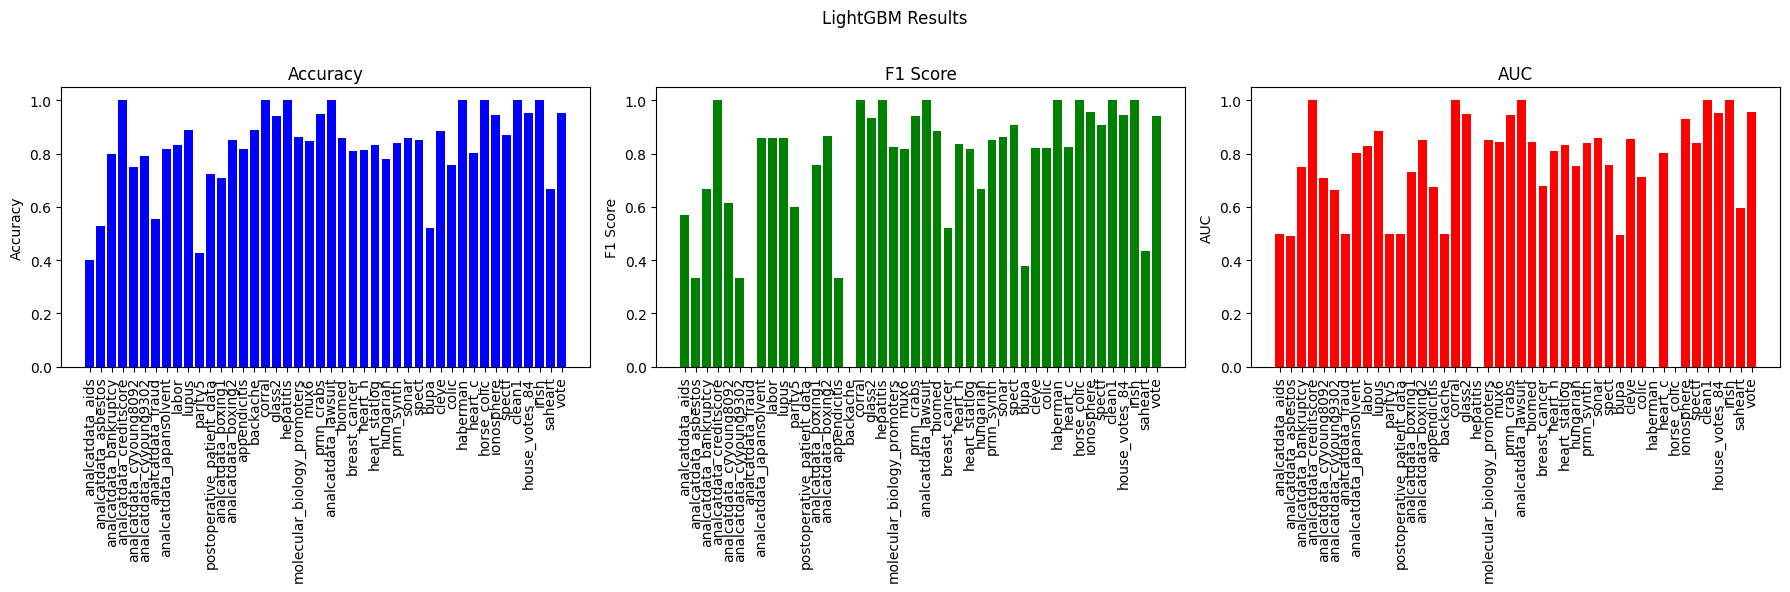

C:\Users\tanhu\AppData\Local\Temp\ipykernel_10860\2511897163.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[0].set_xticklabels(df['Dataset'], rotation=90)
C:\Users\tanhu\AppData\Local\Temp\ipykernel_10860\2511897163.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[1].set_xticklabels(df['Dataset'], rotation=90)
C:\Users\tanhu\AppData\Local\Temp\ipykernel_10860\2511897163.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[2].set_xticklabels(df['Dataset'], rotation=90)


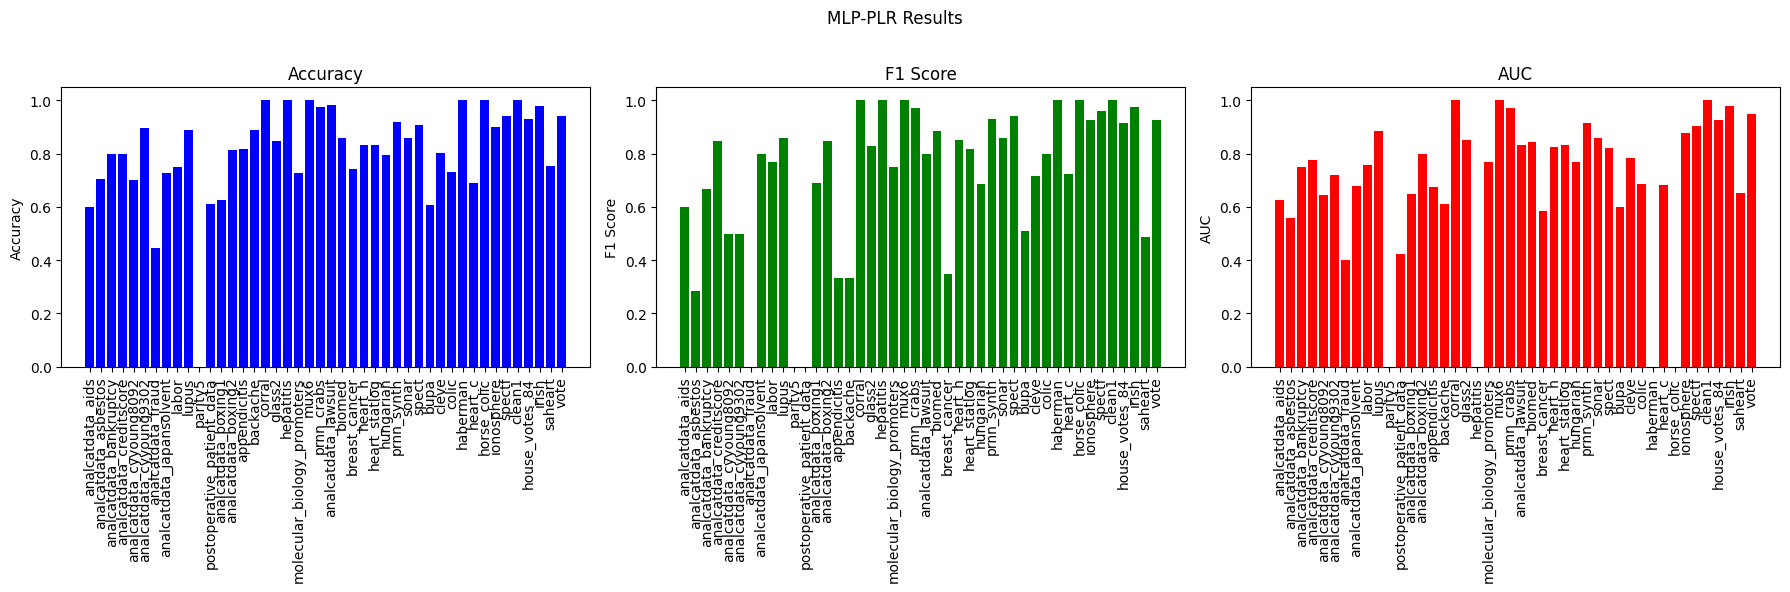

C:\Users\tanhu\AppData\Local\Temp\ipykernel_10860\2511897163.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[0].set_xticklabels(df['Dataset'], rotation=90)
C:\Users\tanhu\AppData\Local\Temp\ipykernel_10860\2511897163.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[1].set_xticklabels(df['Dataset'], rotation=90)
C:\Users\tanhu\AppData\Local\Temp\ipykernel_10860\2511897163.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[2].set_xticklabels(df['Dataset'], rotation=90)


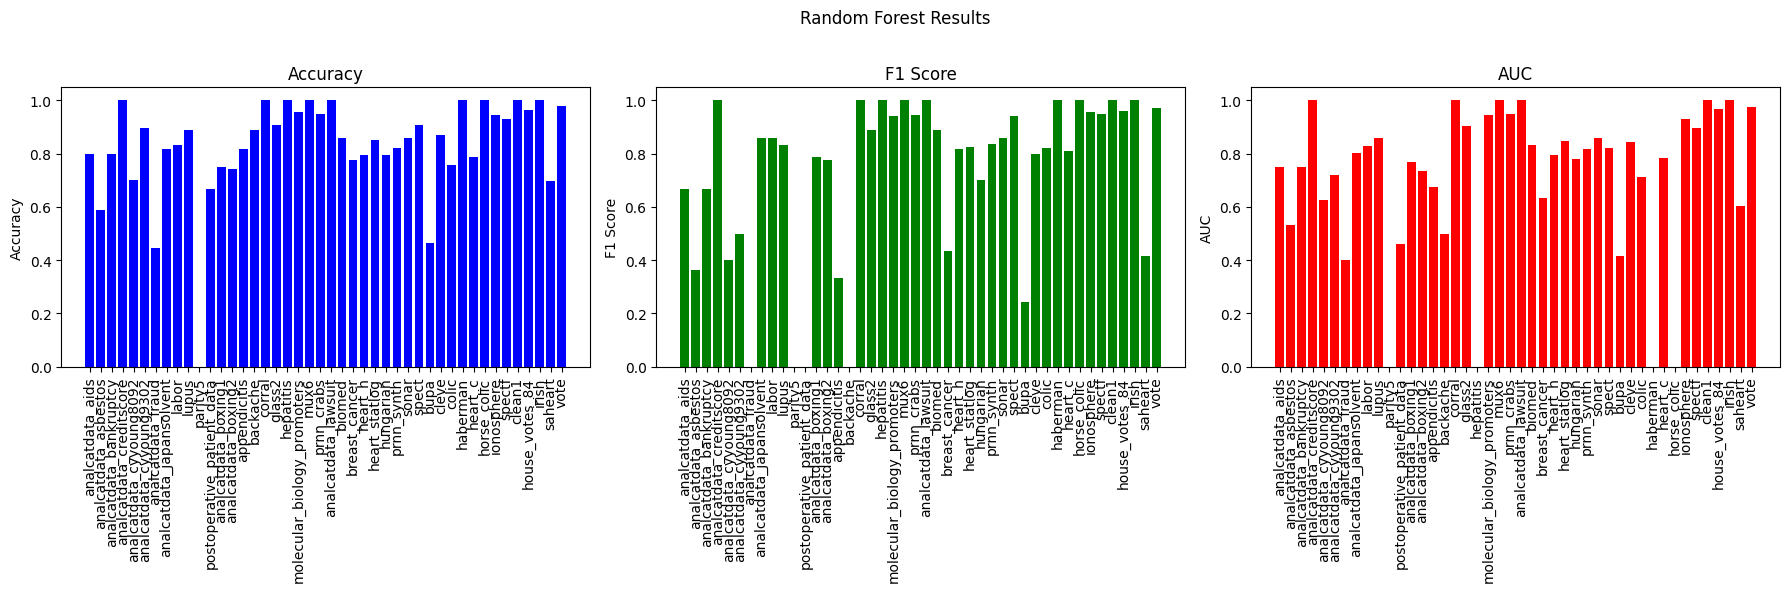

C:\Users\tanhu\AppData\Local\Temp\ipykernel_10860\2511897163.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[0].set_xticklabels(df['Dataset'], rotation=90)
C:\Users\tanhu\AppData\Local\Temp\ipykernel_10860\2511897163.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[1].set_xticklabels(df['Dataset'], rotation=90)
C:\Users\tanhu\AppData\Local\Temp\ipykernel_10860\2511897163.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[2].set_xticklabels(df['Dataset'], rotation=90)


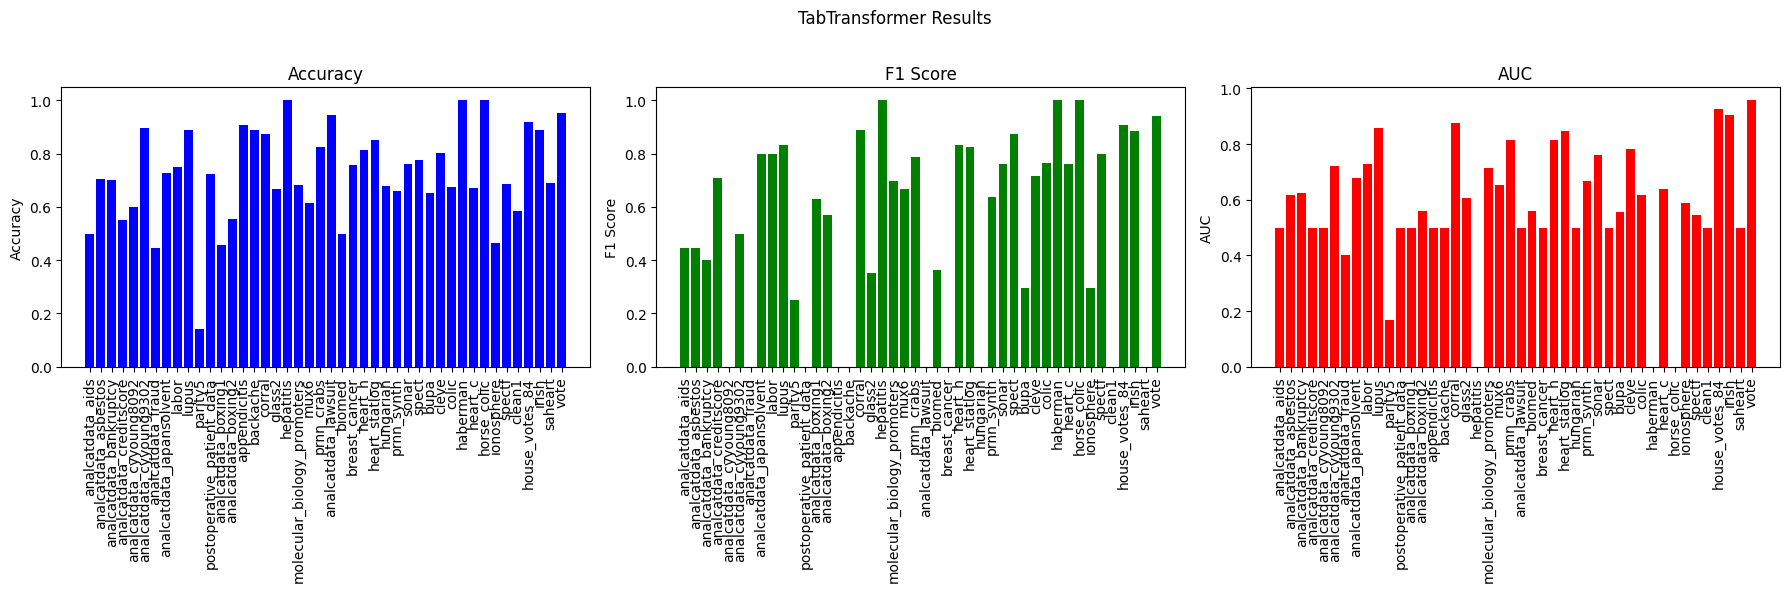

C:\Users\tanhu\AppData\Local\Temp\ipykernel_10860\2511897163.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[0].set_xticklabels(df['Dataset'], rotation=90)
C:\Users\tanhu\AppData\Local\Temp\ipykernel_10860\2511897163.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[1].set_xticklabels(df['Dataset'], rotation=90)
C:\Users\tanhu\AppData\Local\Temp\ipykernel_10860\2511897163.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[2].set_xticklabels(df['Dataset'], rotation=90)


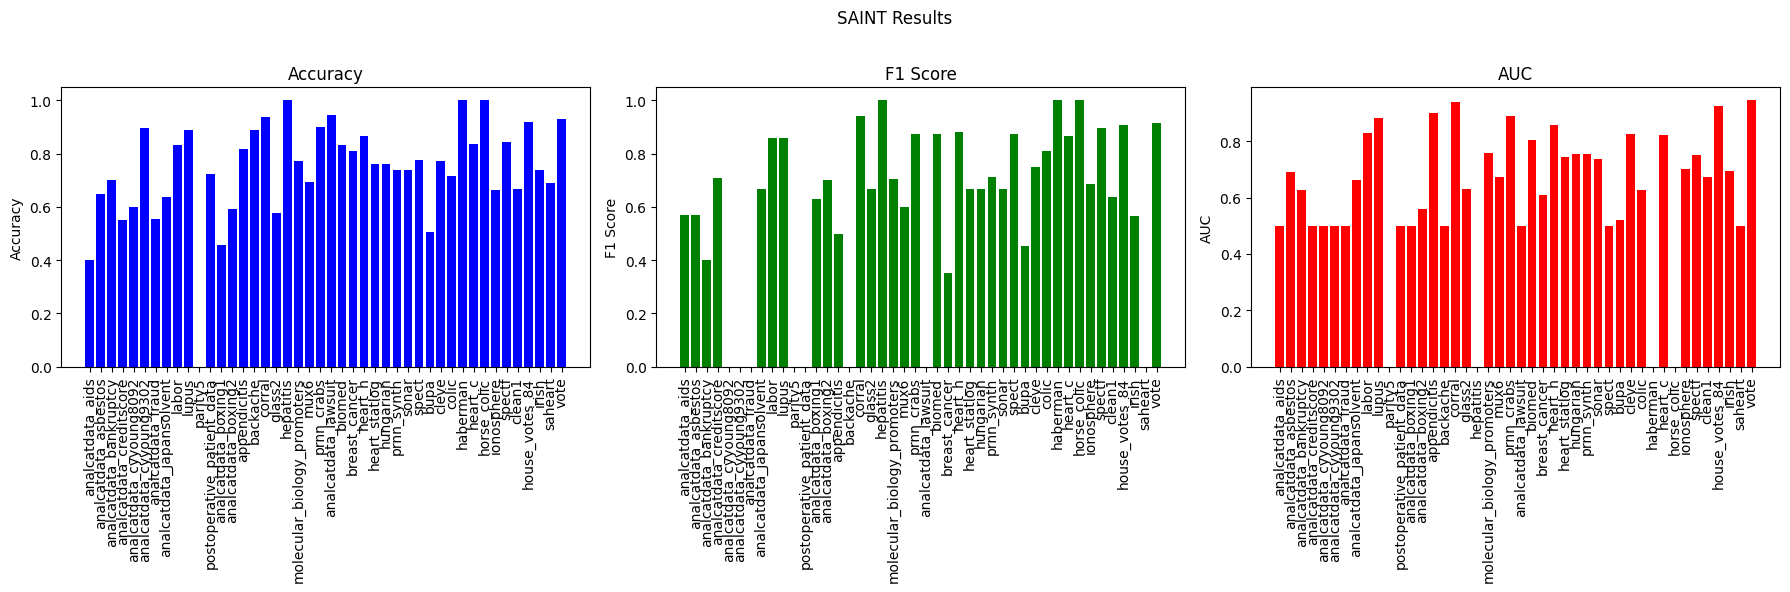

In [4]:
import matplotlib.pyplot as plt

# Định nghĩa một hàm để vẽ biểu đồ cho mỗi mô hình và chỉ số
def plot_model_results(df, model_name):
    # Tạo một figure với ba subplots cho Accuracy, F1, và AUC
    fig, axs = plt.subplots(1, 3, figsize=(18, 6))
    fig.suptitle(f'{model_name} Results')

    # Accuracy
    axs[0].bar(df['Dataset'], df['Accuracy'], color='blue')
    axs[0].set_title('Accuracy')
    axs[0].set_xticklabels(df['Dataset'], rotation=90)
    axs[0].set_ylabel('Accuracy')

    # F1 Score
    axs[1].bar(df['Dataset'], df['F1'], color='green')
    axs[1].set_title('F1 Score')
    axs[1].set_xticklabels(df['Dataset'], rotation=90)
    axs[1].set_ylabel('F1 Score')

    # AUC
    axs[2].bar(df['Dataset'], df['AUC'], color='red')
    axs[2].set_title('AUC')
    axs[2].set_xticklabels(df['Dataset'], rotation=90)
    axs[2].set_ylabel('AUC')

    # Tạo không gian giữa các biểu đồ
    plt.tight_layout()
    plt.subplots_adjust(top=0.85)
    plt.show()

# Vẽ kết quả cho từng mô hình
plot_model_results(lightgbm_df, 'LightGBM')
plot_model_results(mlp_plr_df, 'MLP-PLR')
plot_model_results(rf_df, 'Random Forest')
plot_model_results(tab_transformer_df, 'TabTransformer')
plot_model_results(saint_df, 'SAINT')
